In [3]:
import numpy as np
from tvtk.api import tvtk
from scpy2.tvtk.tvtkhelp import ivtk_scene, event_loop

%matplotlib_svg
import pylab as pl

In [4]:
%gui qt

## TVTK可视化实例

### 切面

> **SOURCE**

> `scpy2.tvtk.example_cut_plane`：切面演示程序

In [35]:
#%hide
%exec_python -m scpy2.tvtk.example_cut_plane

In [5]:
def read_data():
    # 读入数据
    plot3d = tvtk.MultiBlockPLOT3DReader( #❶
        xyz_file_name = "combxyz.bin",
        q_file_name = "combq.bin",
        scalar_function_number = 100, vector_function_number = 200
    )
    plot3d.update() #❷
    return plot3d

plot3d = read_data()
grid = plot3d.output.get_block(0) #❸

# 创建颜色映射表
lut = tvtk.LookupTable() #❹
lut.table = pl.cm.cool(np.arange(0,256))*255

In [4]:
print((type(plot3d.output)))
print((type(plot3d.output.get_block(0))))

<class 'tvtk.tvtk_classes.multi_block_data_set.MultiBlockDataSet'>
<class 'tvtk.tvtk_classes.structured_grid.StructuredGrid'>


In [5]:
print(("dimensions:", grid.dimensions))
print((grid.points.to_array()))
print(("cell arrays:", grid.cell_data.number_of_arrays))
print(("point arrays:", grid.point_data.number_of_arrays))

print("arrays name:")
for i in range(grid.point_data.number_of_arrays):
    print(("    ", grid.point_data.get_array_name(i)))

print(("scalars name:", grid.point_data.scalars.name))
print(("vectors name:", grid.point_data.vectors.name))

dimensions: [57 33 25]
[[  2.66700006  -3.77476001  23.83292007]
 [  2.94346499  -3.74825287  23.66555977]
 [  3.21985817  -3.72175312  23.49823952]
 ..., 
 [ 15.84669018   5.66214085  35.7493782 ]
 [ 16.17829895   5.66214085  35.7493782 ]
 [ 16.51000023   5.66214085  35.7493782 ]]
cell arrays: 0
point arrays: 4
arrays name:
     Density
     Momentum
     StagnationEnergy
     Velocity
scalars name: Density
vectors name: Velocity


In [6]:
# 显示StructuredGrid中的一个网格面
plane = tvtk.StructuredGridGeometryFilter(extent = (0, 100, 0, 100, 6, 6)) #❶
plane.set_input_data(grid) #❷
plane_mapper = tvtk.PolyDataMapper(lookup_table = lut, input_connection = plane.output_port) #❸
plane_mapper.scalar_range = grid.scalar_range #❹
plane_actor = tvtk.Actor(mapper = plane_mapper) #❺

> **WARNING**

> `TVTK`库没有将`SetInputData()`转换成`input_data`属性，因此需要调用其对应的`set_input_data()`函数设置输入数据集。

In [7]:
plane.update()
p = plane.output
type(p)

tvtk.tvtk_classes.poly_data.PolyData

In [8]:
print((p.number_of_points, grid.dimensions[0] * grid.dimensions[1]))

1881 1881


In [9]:
print((grid.dimensions))
points1 = grid.points.to_array().reshape((25,33,57,3))
points2 = p.points.to_array().reshape((33,57,3))
np.all(points1[6] == points2)

[57 33 25]


True

In [10]:
print((p.point_data.number_of_arrays))
print((p.point_data.scalars.name))

4
Density


In [11]:
lut2 = tvtk.LookupTable()
lut2.table = pl.cm.cool(np.arange(0,256))*255
cut_plane = tvtk.Plane(origin = grid.center, normal=(-0.287, 0, 0.9579)) #❶
cut = tvtk.Cutter(cut_function = cut_plane) #❷
cut.set_input_data(grid)
cut_mapper = tvtk.PolyDataMapper(input_connection = cut.output_port, lookup_table = lut2)
cut_actor = tvtk.Actor(mapper = cut_mapper)

In [12]:
type(plane.output)

tvtk.tvtk_classes.poly_data.PolyData

In [13]:
cut.update()
cut.output.number_of_points

2537

In [14]:
cut.output.point_data.number_of_arrays

4

In [7]:
def make_outline(input_obj):
    from tvtk.common import configure_input
    outline = tvtk.StructuredGridOutlineFilter()
    configure_input(outline, input_obj)
    outline_mapper = tvtk.PolyDataMapper(input_connection = outline.output_port)
    outline_actor = tvtk.Actor(mapper = outline_mapper)
    outline_actor.property.color = 0.3, 0.3, 0.3
    return outline_actor

outline_actor = make_outline(grid)

In [16]:
win = ivtk_scene([plane_actor, cut_actor, outline_actor])
win.scene.isometric_view()

### 等值面

> **SOURCE**

> `scpy2.tvtk.example_contours`：使用等值面可视化标量场

In [20]:
#%hide
%exec_python -m scpy2.tvtk.example_contours

In [8]:
contours = tvtk.ContourFilter()
contours.set_input_data(grid)
contours.generate_values(8, grid.point_data.scalars.range) #❶
mapper = tvtk.PolyDataMapper(input_connection = contours.output_port,
    scalar_range = grid.point_data.scalars.range) #❷
actor = tvtk.Actor(mapper = mapper)
actor.property.opacity = 0.3 #❸

outline_actor = make_outline(grid)

win = ivtk_scene([actor, outline_actor])
win.scene.isometric_view()

In [40]:
print((contours.get_value(0)))
contours.set_value(0, 0.21)

0.197813093662


In [45]:
plot3d = read_data()
plot3d.add_function(153) #❶
plot3d.update()
grid = plot3d.output.get_block(0)

contours = tvtk.ContourFilter()
contours.set_input_data(grid)
contours.set_value(0, 0.30) #❷
mapper = tvtk.PolyDataMapper(input_connection = contours.output_port,
    scalar_range = grid.point_data.get_array(4).range, #❸
    scalar_mode = "use_point_field_data") #❹
mapper.color_by_array_component("VelocityMagnitude", 0) #❺
actor = tvtk.Actor(mapper = mapper)
actor.property.opacity = 0.6 

outline_actor = make_outline(grid)

win = ivtk_scene([actor, outline_actor])
win.scene.isometric_view()

In [42]:
grid.point_data.get_array_name(4)

'VelocityMagnitude'

### 流线

> **SOURCE**

> `scpy2.tvtk.example_streamline`：使用流线和箭头可视化矢量场

In [58]:
#%hide
%exec_python -m scpy2.tvtk.example_streamline

In [67]:
# 矢量箭头
mask = tvtk.MaskPoints(random_mode=True, on_ratio=50) #❶
mask.set_input_data(grid)

arrow_source = tvtk.ArrowSource() #❷
arrows = tvtk.Glyph3D(input_connection = mask.output_port, #❸
    scale_factor=2/np.max(grid.point_data.scalars.to_array()))
arrows.set_source_connection(arrow_source.output_port)
arrows_mapper = tvtk.PolyDataMapper(input_connection = arrows.output_port, 
    scalar_range = grid.point_data.scalars.range)
arrows_actor = tvtk.Actor(mapper = arrows_mapper)

In [68]:
print((grid.number_of_points))
mask.update()
print((type(mask.output)))
print((mask.output.number_of_points))
print((mask.output.point_data.number_of_arrays)) 

47025
<class 'tvtk.tvtk_classes.poly_data.PolyData'>
952
5


> **WARNING**

> 由于`TVTK`没有提供`source_connection`属性，因此只能通过`set_source_connection()`设置`Glyph3D`对象的输入。

In [69]:
arrows.update()
print((arrow_source.output.number_of_points)) # 一个箭头有31个点
print((arrows.output.number_of_points)) # 箭头被复制了N份，因此有N*31个点

31
29512


In [71]:
center = grid.center
sphere = tvtk.SphereSource(  #❶
    center=(2, center[1], center[2]), radius=2, 
    phi_resolution=6, theta_resolution=6)
sphere_mapper = tvtk.PolyDataMapper(input_connection=sphere.output_port)
sphere_actor = tvtk.Actor(mapper=sphere_mapper)
sphere_actor.property.set(
    representation = "wireframe", color=(0,0,0))

# 流线    
streamer = tvtk.StreamLine( #❷
    step_length=0.0001,
    integration_direction="forward", 
    integrator=tvtk.RungeKutta4()) #❸
streamer.set_input_data(grid)
streamer.set_source_connection(sphere.output_port)

tube = tvtk.TubeFilter( #❹
    input_connection=streamer.output_port,
    radius=0.05,
    number_of_sides=6,
    vary_radius="vary_radius_by_scalar")

tube_mapper = tvtk.PolyDataMapper(
    input_connection=tube.output_port,
    scalar_range=grid.point_data.scalars.range)
tube_actor = tvtk.Actor(mapper=tube_mapper)  
tube_actor.property.backface_culling = True

outline_actor = make_outline(grid)
win = ivtk_scene([outline_actor, sphere_actor, tube_actor, arrows_actor])
win.scene.isometric_view()

In [72]:
streamer.update()
print((streamer.output.number_of_points))
print((streamer.output.number_of_polys))
print((streamer.output.number_of_lines))

5528
0
23


In [74]:
tube.update()
tube.output.number_of_polys

0

In [75]:
print((tube.output.number_of_strips))
t = tube.output.get_cell(0)
print((type(t)))
print((t.number_of_points))

138
<class 'tvtk.tvtk_classes.triangle_strip.TriangleStrip'>
498


In [77]:
point_data = grid.point_data
point_data.scalars = np.sqrt(np.sum(point_data.vectors.to_array()**2, axis=-1))

> **TIP**

> `grid`是数据集对象，而`vnorm`为`Algorithm`对象。为了让程序兼容这两种不同的输入类型，可以使用`tvtk.common.configure_input()`。

In [78]:
vnorm = tvtk.VectorNorm()
vnorm.set_input_data(grid)

### 计算圆柱的相贯线

> **SOURCE**

> `scpy2.tvtk.example_tube_intersection`：计算两个圆管的相贯线，可通过界面中的滑块控件修改圆管的内径和外径。

In [83]:
#%hide
%exec_python -m scpy2.tvtk.example_tube_intersection

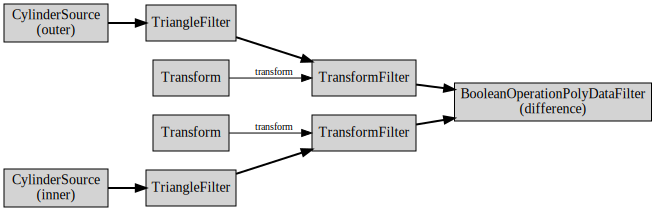

In [73]:
#%figonly=生成圆管的流水线
graph = u"""
digraph structs {
rankdir="LR";        
node [shape=record,style=filled];
edge [fontsize=10, penwidth=2.0];
CylinderSource[label="CylinderSource\n(outer)"];
CylinderSource -> TriangleFilter;
TriangleFilter -> TransformFilter;
Transform -> TransformFilter [label="transform", penwidth=1.0];
TransformFilter -> BooleanOperationPolyDataFilter;
BooleanOperationPolyDataFilter[label="BooleanOperationPolyDataFilter\n(difference)"];

CylinderSource2[label="CylinderSource\n(inner)"];
TriangleFilter2[label=TriangleFilter];
TransformFilter2[label=TransformFilter];
Transform2[label=Transform];
CylinderSource2 -> TriangleFilter2;
TriangleFilter2 -> TransformFilter2;
Transform2 -> TransformFilter2 [label="transform", penwidth=1.0];
TransformFilter2 -> BooleanOperationPolyDataFilter;

//BooleanOperationPolyDataFilter -> Tube;
}
"""
%dot graph

In [9]:
def make_tube(height, radius, resolution, rx=0, ry=0, rz=0):
    cs1 = tvtk.CylinderSource(height=height, radius=radius[0], resolution=resolution) #❶
    cs2 = tvtk.CylinderSource(height=height+0.1, radius=radius[1], resolution=resolution)    
    triangle1 = tvtk.TriangleFilter(input_connection=cs1.output_port) #❷
    triangle2 = tvtk.TriangleFilter(input_connection=cs2.output_port)
    tr = tvtk.Transform()
    tr.rotate_x(rx)
    tr.rotate_y(ry)
    tr.rotate_z(rz)
    tf1 = tvtk.TransformFilter(transform=tr, input_connection=triangle1.output_port)   #❸
    tf2 = tvtk.TransformFilter(transform=tr, input_connection=triangle2.output_port)   
    bf = tvtk.BooleanOperationPolyDataFilter() #❹
    bf.operation = "difference"
    bf.set_input_connection(0, tf1.output_port)
    bf.set_input_connection(1, tf2.output_port)
    m = tvtk.PolyDataMapper(input_connection=bf.output_port, scalar_visibility=False)
    a = tvtk.Actor(mapper=m)
    a.property.color = 0.7, 0.7, 0.7
    return bf, a, tf1, tf2

tube1, tube1_actor, tube1_outer, tube1_inner = make_tube(5, [1, 0.8], 32)
tube2, tube2_actor, tube2_outer, tube2_inner = make_tube(5, [0.7, 0.55], 32, rx=90)

win = ivtk_scene([tube1_actor, tube2_actor])
win.scene.isometric_view()

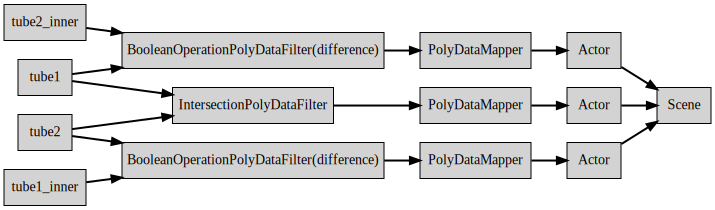

In [1]:
#%figonly=计算相贯线的流水线
graph = """
digraph structs {
rankdir="LR";        
node [shape=record,style=filled];
edge [fontsize=10, penwidth=2.0];
tube1 -> BooleanOperationPolyDataFilter;
tube2_inner -> BooleanOperationPolyDataFilter;

tube2 -> BooleanOperationPolyDataFilter2;
tube1_inner -> BooleanOperationPolyDataFilter2;

BooleanOperationPolyDataFilter[label="BooleanOperationPolyDataFilter\n(difference)"];
BooleanOperationPolyDataFilter2[label="BooleanOperationPolyDataFilter\n(difference)"];

tube1 -> IntersectionPolyDataFilter;
tube2 -> IntersectionPolyDataFilter;

BooleanOperationPolyDataFilter -> PolyDataMapper1;
IntersectionPolyDataFilter -> PolyDataMapper2;
BooleanOperationPolyDataFilter2 -> PolyDataMapper3;

PolyDataMapper1[label=PolyDataMapper];
PolyDataMapper2[label=PolyDataMapper];
PolyDataMapper3[label=PolyDataMapper];

PolyDataMapper1 -> Actor1;
PolyDataMapper2 -> Actor2;
PolyDataMapper3 -> Actor3;

Actor1[label=Actor];
Actor2[label=Actor];
Actor3[label=Actor];

Actor1 -> Scene;
Actor2 -> Scene;
Actor3 -> Scene;
}
"""
%dot graph

In [10]:
def difference(pd1, pd2):
    bf = tvtk.BooleanOperationPolyDataFilter()
    bf.operation = "difference"
    bf.set_input_connection(0, pd1.output_port)
    bf.set_input_connection(1, pd2.output_port)
    m = tvtk.PolyDataMapper(input_connection=bf.output_port, scalar_visibility=False)
    a = tvtk.Actor(mapper=m)
    return bf, a

def intersection(pd1, pd2, color=(1.0, 0, 0), width=2.0):
    ipd = tvtk.IntersectionPolyDataFilter()
    ipd.set_input_connection(0, pd1.output_port)
    ipd.set_input_connection(1, pd2.output_port)
    m = tvtk.PolyDataMapper(input_connection=ipd.output_port)
    a = tvtk.Actor(mapper=m)
    a.property.diffuse_color = 1.0, 0, 0 #❶
    a.property.line_width = 2.0    
    return ipd, a

tube1_hole, tube1_hole_actor = difference(tube1, tube2_inner)
tube2_hole, tube2_hole_actor = difference(tube2, tube1_inner)
intersecting_line, intersecting_line_actor = intersection(tube1, tube2)

tube1_hole_actor.property.opacity = 0.8
tube2_hole_actor.property.opacity = 0.8
tube1_hole_actor.property.color = 0.5, 0.5, 0.5
tube2_hole_actor.property.color = 0.5, 0.5, 0.5

win = ivtk_scene([tube1_hole_actor, tube2_hole_actor, intersecting_line_actor])
win.scene.isometric_view()

In [87]:
print((intersecting_line.output.points.number_of_points))
print((intersecting_line.output.lines.number_of_cells))

1624
1650


In [11]:
from scipy.spatial import distance

dist = distance.squareform( distance.pdist(intersecting_line.output.points.to_array()) )
dist[np.diag_indices(dist.shape[0])] = np.inf
dist = dist.ravel()
print((np.sort(dist)[:10]))

[  1.60932541e-06   1.60932541e-06   1.66893005e-06   1.66893005e-06
   3.23077305e-06   3.23077305e-06   3.23077305e-06   3.23077305e-06
   3.72555819e-06   3.72555819e-06]


In [12]:
cpd = tvtk.CleanPolyData(tolerance_is_absolute=True, 
                         absolute_tolerance=1e-5,
                         input_connection=intersecting_line.output_port)
cpd.update()
cpd.output.points.number_of_points

1578

C:\WinPython-32bit-2.7.9.2\python-2.7.9\lib\site-packages\matplotlib\font_manager.py:1282: UserWarning: findfont: Font family [u'WenQuanYi Micro Hei'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


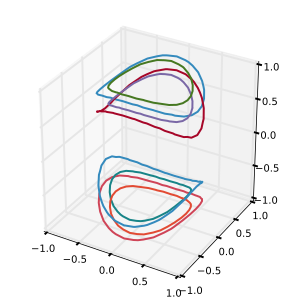

In [13]:
#%fig=用matplotlib绘制提取出的相贯线
from collections import defaultdict

def connect_lines(lines):
    edges = defaultdict(set)    
    for _, s, e in lines.to_array().reshape(-1, 3).tolist():
        edges[s].add(e)
        edges[e].add(s)

    while True:
        if not edges:
            break
        poly = [next(iter(list(edges.keys())))]
        while True:
            e = poly[-1]
            neighbours = edges[e]
            if not neighbours:
                break
            n = neighbours.pop()
            try:
                edges[n].remove(e)
            except:
                pass
            poly.append(n)
        yield poly
        edges = {k:v for k,v in list(edges.items()) if v}
        
from mpl_toolkits.mplot3d import Axes3D

fig = pl.figure(figsize=(5, 5))
ax = fig.gca(projection='3d')

points = cpd.output.points.to_array()
for line in connect_lines(cpd.output.lines):
    x, y, z = points[line].T
    ax.plot(x, y, z, label='parametric curve')

ax.auto_scale_xyz([-1, 1], [-1, 1], [-1, 1])